<a href="https://colab.research.google.com/github/EricSiq/Understanding-DeepLearning/blob/main/Experiment_No6_XRay_Classification_Pneumonia_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Learning Lab Experiment 6
Problem Statement **XRay Classification Pneumonia using Convolution Neural Nets**

By *Eric Siqueira*

AIML A2

PRN: 23070126041
---


Objectives:

1. Study the Pueunmonia dataset.

2. Study CNN in detail.

3. Implement the same with google colab.

# Calling libraries for code

In [ ]:
# Import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import shutil

# Data Download and Preparation

In [1]:

# This block automates downloading the dataset from Kaggle to local memory of Colab.
# It uploads 'kaggle.json' file with your Kaggle Account API credentials.
try:
    # Attempts to install the Kaggle library
    !pip install -q kaggle

    # Checks if kaggle.json is present
    if not os.path.exists('/root/.kaggle/kaggle.json'):
        print("Kaggle credentials not found. Please upload your kaggle.json file.")
        from google.colab import files
        files.upload() # This will prompt you to upload the file
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json

    # Downloads the dataset
    dataset_name = 'paultimothymooney/chest-xray-pneumonia'
    zip_file = 'chest-xray-pneumonia.zip'
    dataset_dir = 'chest_xray'

    if not os.path.exists(dataset_dir):
        print(f"Downloading dataset: {dataset_name}...")
        !kaggle datasets download -d {dataset_name}
        print(f"Unzipping {zip_file}...")
        !unzip -q {zip_file}
        print("Dataset successfully downloaded and unzipped.")
    else:
        print("Dataset already exists. Skipping download.")

except Exception as e:
    print(f"An error occurred during data setup: {e}")

Kaggle credentials not found. Please upload your kaggle.json file.


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:26<00:00, 159MB/s]
100% 2.29G/2.29G [00:26<00:00, 93.9MB/s]
Unzipping chest-xray-pneumonia.zip...
Dataset successfully downloaded and unzipped.


# Define Data Generators with Augmentation

In [2]:

try:
    # Defines paths of the dataset folders
    train_dir = os.path.join(dataset_dir, 'chest_xray', 'train')
    val_dir = os.path.join(dataset_dir, 'chest_xray', 'val')
    test_dir = os.path.join(dataset_dir, 'chest_xray', 'test')

    # error check for folder existence
    if not all(os.path.exists(d) for d in [train_dir, val_dir, test_dir]):
        raise FileNotFoundError("Dataset directories not found. Please check paths.")

    # Data augmentation for the training set to prevent overfitting
    train_datagen = ImageDataGenerator(
        rescale=1./255,           # Normalize pixel values
        rotation_range=20,        # Randomly rotate images
        width_shift_range=0.2,    # Randomly shift images horizontally
        height_shift_range=0.2,   # Randomly shift images vertically
        shear_range=0.2,          # Apply shearing transformations
        zoom_range=0.2,           # Randomly zoom into images
        horizontal_flip=True,     # Flip images horizontally
        fill_mode='nearest'       # Strategy for filling in new pixels
    )

    # rescales validation and test data
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Uses flow_from_directory to create generators
    IMG_SIZE = 150
    BATCH_SIZE = 32

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False  # Crucial for test set evaluation
    )

except Exception as e:
    print(f"An error occurred during data preprocessing: {e}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Build the CNN Model

In [4]:

try:
    model = Sequential([
        # First block: Conv -> Batch Norm -> ReLU -> MaxPool
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Second block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Third block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Fully connected layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5), # Add dropout for regularization
        Dense(1, activation='sigmoid') # Binary classification output
    ])

    #  Compile the Model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    #  Train the Model
    print("Starting model training...")
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=5, # Increased epochs for better learning
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE
    )

    print("Training complete.")

except Exception as e:
    print(f"An error occurred during model building or training: {e}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,035,073 (72.61 MB)

 Trainable params: 19,034,625 (72.61 MB)

 Non-trainable params: 448 (1.75 KB)

Starting model training...
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step - accuracy: 0.7885 - loss: 3.6886 - val_accuracy: 0.5000 - val_loss: 40.5804
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 561s 3s/step - accuracy: 0.8659 - loss: 0.3798 - val_accuracy: 0.5000 - val_loss: 41.6715
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 566s 3s/step - accuracy: 0.8775 - loss: 0.2913 - val_accuracy: 0.5000 - val_loss: 20.2210
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 625s 3s/step - accuracy: 0.8972 - loss: 0.2900 - val_accuracy: 0.5000 - val_loss: 38.1013
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 655s 4s/step - accuracy: 0.8915 - loss: 0.2733 - val_accuracy: 0.5000 - val_loss: 4.5042
Training complete.


#  Evaluate the Model on the Test Set

Evaluating model on the test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 709ms/step - accuracy: 0.3183 - loss: 4.3627

Test Accuracy: 0.6346
Test Loss: 2.4180
Generating training history plots...


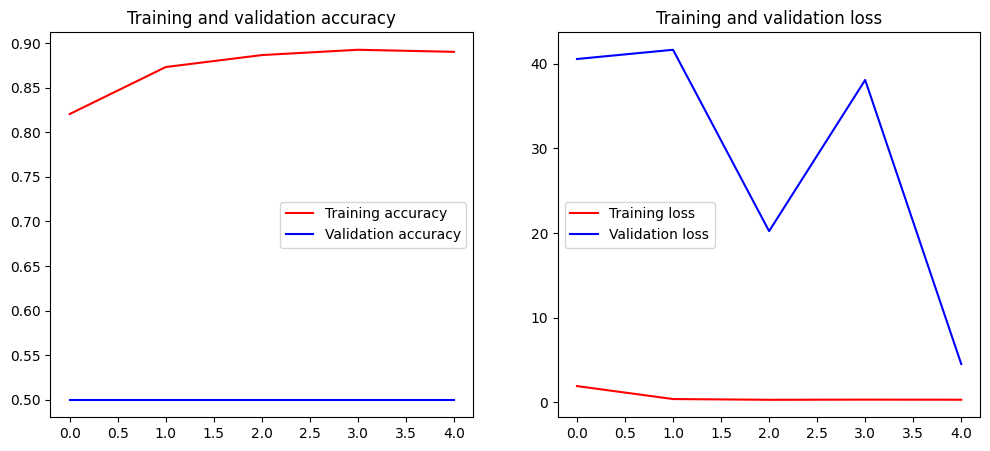

Model saved as 'pneumonia_classifier.h5'.


In [5]:

try:
    print("Evaluating model on the test set...")
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\nTest Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Visualize Training History
    print("Generating training history plots...")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    #  Save the Model
    model.save('pneumonia_classifier.h5')
    print("Model saved as 'pneumonia_classifier.h5'.")

except Exception as e:
    print(f"An error occurred during evaluation or plotting: {e}")